# Decision Tree (tau) [vif10]
This is a simple, yet powerful algorithm that can be used for both regression and classification problems. It works well with categorical data, as well as data with non-linear relationships.

https://scikit-learn.org/stable/modules/tree.html#regression

tree.DecisionTreeRegressor()

{'ccp_alpha': 0.0,   
 'criterion': 'squared_error',   
 'max_depth': None,   
 'max_features': None,   
 'max_leaf_nodes': None,   
 'min_impurity_decrease': 0.0,   
 'min_samples_leaf': 1,   
 'min_samples_split': 2,   
 'min_weight_fraction_leaf': 0.0,   
 'random_state': None,   
 'splitter': 'best'}   
 
**_bayesian hyperparameter tuning_**

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import platform
import seaborn as sns
from sklearn import linear_model
from sklearn import tree
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize, space
from skopt.space import Real, Integer
import sys

from validation import cross_validation
from validation import performance_test_shifted

date_format = '%Y-%m-%d'

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

In [2]:
# config 'all', 'vif_5' or 'vif_10'
vif = 'vif_10'

# config model
ml_algorithm = tree.DecisionTreeRegressor
filename = 'single-model_tau_dt'

In [3]:
my_os = platform.system()
print('OS in my system: ',my_os)

if my_os == 'Windows':
    path = str(pathlib.Path().absolute()) + '\\'
    slash = '\\'
else:
    path = str(pathlib.Path().absolute()) + '/'
    slash = '/'

path_3 = path.replace('4_modelling', '3_data_pre-processing')

OS in my system:  Linux


## Load Data

In [4]:
data_set = pd.read_csv(path_3 + 'data_artifacts' + slash + 'data_set_e_spx_3-' + vif + '.csv', index_col=0)

## Original Target Model (no forecast horizon)
### Time Series Cross Validation on Default Model

In [5]:
default_model = ml_algorithm(random_state=23)
default_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 23,
 'splitter': 'best'}

In [6]:
default_model_scores_ori = cross_validation (data_set, default_model, 'tau_target_ori')
pd.DataFrame(default_model_scores_ori).describe()

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.0,10.000000,10.0,10.000000,10.0,10.000000
mean,0.0,0.008597,0.0,0.072220,1.0,0.604576
std,0.0,0.002516,0.0,0.011631,0.0,0.183422
min,0.0,0.006308,0.0,0.061723,1.0,0.192231
25%,0.0,0.006698,0.0,0.063616,1.0,0.513928
50%,0.0,0.007694,0.0,0.068191,1.0,0.647971
75%,0.0,0.010561,0.0,0.080539,1.0,0.743471
max,0.0,0.013247,0.0,0.094031,1.0,0.793569


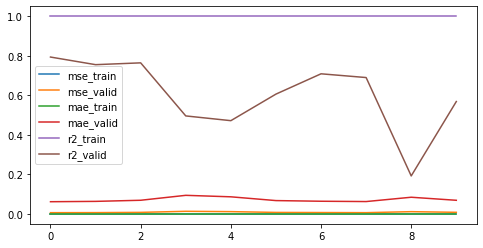

In [7]:
ax = pd.DataFrame(default_model_scores_ori).plot(figsize=(8,4))

### Hyperparameter Optimization with Time Series Cross Validation
- Bayesian optimization
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

In [8]:
# search space for the hyperparameters
space = [Integer(1, 50, name='max_depth'),
         Integer(2, 200, name='min_samples_split'),
         Integer(1, 200, name='min_samples_leaf')]

Optimal point: [6, 45, 167]
Function value at optimal point: 0.0048564634898229575


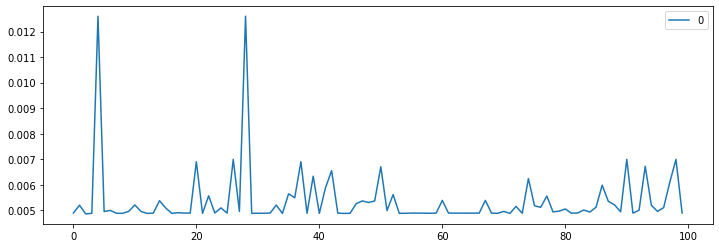

In [9]:
# objective function to minimize
def objective(params):
    max_depth, min_samples_split, min_samples_leaf = params
    model = ml_algorithm(max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf), random_state=23)
    scores = cross_validation(data_set, model, 'tau_target_ori')
    return np.mean(scores['mse_valid'])

# perform the optimization
result = gp_minimize(objective, space, n_calls=100, n_random_starts=20, acq_func='EI', acq_optimizer='auto', random_state=23, n_jobs=-1)

# optimal point and function value
print('Optimal point:', result.x)
print('Function value at optimal point:', result.fun)
ax = pd.DataFrame(result.func_vals).plot(figsize=(12,4))

### Time Series Cross Validation on Optimal Model

In [10]:
# ---------------- config opt model -----------------
opt_model_ori = ml_algorithm(max_depth=6, min_samples_split=45, min_samples_leaf=167, random_state=23)

In [11]:
opt_model_ori_tscv_scores = cross_validation(data_set, opt_model_ori, 'tau_target_ori')
opt_model_ori_tscv_scores = pd.DataFrame(opt_model_ori_tscv_scores)
display(opt_model_ori_tscv_scores)
display(opt_model_ori_tscv_scores.describe())

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
0,0.003517,0.002730,0.046514,0.041299,0.856249,0.910667
1,0.003369,0.003887,0.045116,0.049077,0.874097,0.855717
2,0.003180,0.004907,0.043971,0.056573,0.884169,0.851997
3,0.003344,0.009636,0.045186,0.082523,0.888200,0.633215
4,0.003940,0.007702,0.049200,0.073463,0.867641,0.648745
5,0.004455,0.003177,0.052834,0.044003,0.847629,0.834717
6,0.004369,0.002977,0.052321,0.044241,0.846422,0.876105
7,0.004192,0.002588,0.051321,0.040473,0.852911,0.874246
8,0.003893,0.007522,0.048904,0.071111,0.858369,0.466482
9,0.004268,0.003440,0.051628,0.046663,0.840623,0.816199


,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.003853,0.004856,0.048699,0.054943,0.861631,0.776809
std,0.000470,0.002517,0.003304,0.015277,0.016295,0.144291
min,0.003180,0.002588,0.043971,0.040473,0.840623,0.466482
25%,0.003406,0.003027,0.045518,0.044063,0.848949,0.690608
50%,0.003916,0.003664,0.049052,0.047870,0.857309,0.843357
75%,0.004249,0.006868,0.051551,0.067476,0.872483,0.869614
max,0.004455,0.009636,0.052834,0.082523,0.888200,0.910667


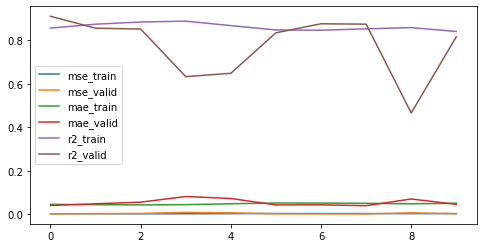

In [12]:
ax = opt_model_ori_tscv_scores[['mse_train', 'mse_valid', 'mae_train', 'mae_valid', 'r2_train', 'r2_valid']].plot(figsize=(8,4))

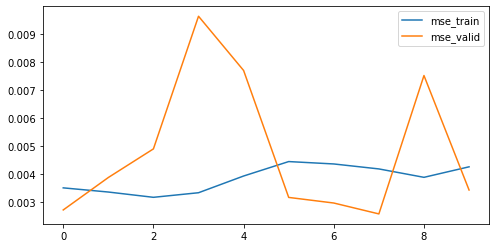

In [13]:
ax = opt_model_ori_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

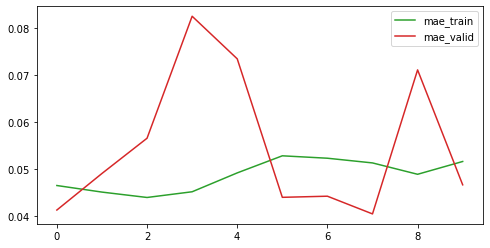

In [14]:
ax = opt_model_ori_tscv_scores[['mae_train', 'mae_valid']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

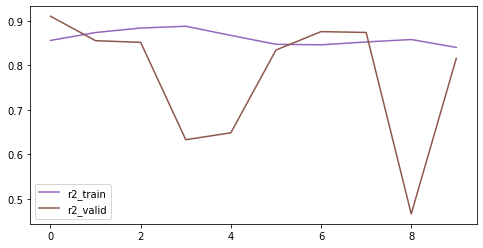

In [15]:
ax = opt_model_ori_tscv_scores[['r2_train', 'r2_valid']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

### Model Performance on Test Set

In [16]:
opt_model_ori_test_scores = performance_test_shifted(data_set, opt_model_ori, 'tau_target_ori')
opt_model_ori_test_scores = pd.DataFrame(opt_model_ori_test_scores)
display(opt_model_ori_test_scores)
display(opt_model_ori_test_scores.describe())

,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
0,0.003377,0.003953,0.045248,0.049477,0.873199,0.853266,0.366445,0.389544
1,0.003360,0.004944,0.045081,0.057048,0.877111,0.850864,0.425448,0.397855
2,0.003341,0.009545,0.045243,0.082073,0.887942,0.636650,0.330819,0.392671
3,0.003983,0.007538,0.049680,0.072778,0.864532,0.656233,0.286654,0.350994
4,0.004312,0.003201,0.051942,0.044099,0.851692,0.833470,0.281294,0.284004
5,0.004204,0.002963,0.051089,0.043899,0.851564,0.876665,0.288558,0.271861
6,0.004110,0.002636,0.050682,0.040809,0.854122,0.871927,0.291026,0.286774
7,0.003952,0.007771,0.049571,0.072505,0.857201,0.448846,0.199579,0.262101
8,0.004206,0.003381,0.051140,0.046402,0.847544,0.819357,0.245124,0.233165
9,0.004126,0.003557,0.050677,0.048675,0.842237,0.829074,0.245513,0.216866


,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.003897,0.004949,0.049035,0.055776,0.860714,0.767635,0.296046,0.308584
std,0.000386,0.002439,0.002740,0.014687,0.014592,0.141029,0.064764,0.068380
min,0.003341,0.002636,0.045081,0.040809,0.842237,0.448846,0.199579,0.216866
25%,0.003521,0.003246,0.046329,0.044675,0.851596,0.697014,0.254458,0.264541
50%,0.004047,0.003755,0.050179,0.049076,0.855662,0.831272,0.287606,0.285389
75%,0.004184,0.006889,0.050987,0.068640,0.871032,0.852665,0.320871,0.379906
max,0.004312,0.009545,0.051942,0.082073,0.887942,0.876665,0.425448,0.397855


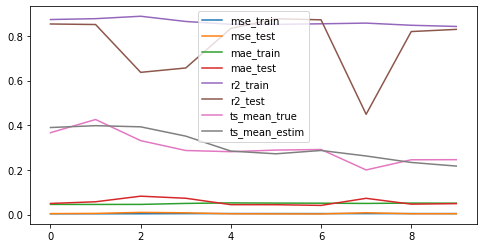

In [17]:
ax = opt_model_ori_test_scores.plot(figsize=(8,4))

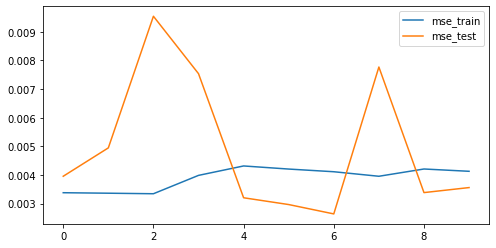

In [18]:
ax = opt_model_ori_test_scores[['mse_train', 'mse_test']].plot(figsize=(8,4))

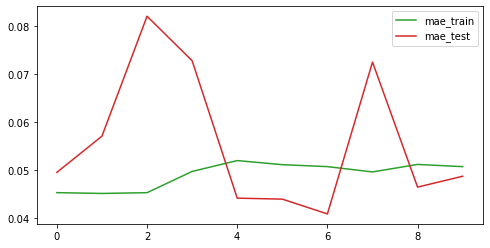

In [19]:
ax = opt_model_ori_test_scores[['mae_train', 'mae_test']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

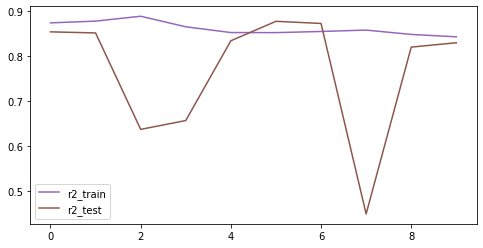

In [20]:
ax = opt_model_ori_test_scores[['r2_train', 'r2_test']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

(0.2, 0.45)

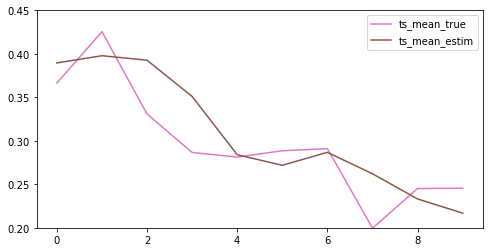

In [21]:
ax = opt_model_ori_test_scores[['ts_mean_true', 'ts_mean_estim']].plot(figsize=(8,4), color=['#e377c2', '#8c564b'])
plt.ylim([0.2,0.45])

### Data for Storage

In [22]:
results_ori = {'Model': [opt_model_ori],
            'fc_horizon': 0,
            'vif': [vif],
            'mse_tscv_t': [opt_model_ori_tscv_scores.mse_train.mean()],
            'mse_tscv_v': [opt_model_ori_tscv_scores.mse_valid.mean()],
            'mse_train': [opt_model_ori_test_scores.mse_train.mean()],
            'mse_test': [opt_model_ori_test_scores.mse_test.mean()],
               
            'mae_tscv_t': [opt_model_ori_tscv_scores.mae_train.mean()],
            'mae_tscv_v': [opt_model_ori_tscv_scores.mae_valid.mean()],
            'mae_train': [opt_model_ori_test_scores.mae_train.mean()],
            'mae_test': [opt_model_ori_test_scores.mae_test.mean()],
               
            'r2_tscv_t': [opt_model_ori_tscv_scores.r2_train.mean()],
            'r2_tscv_v': [opt_model_ori_tscv_scores.r2_valid.mean()],
            'r2_train': [opt_model_ori_test_scores.r2_train.mean()],
            'r2_test': [opt_model_ori_test_scores.r2_test.mean()],
               
            'opt_model': [opt_model_ori.get_params()],
            'ts_mean_true': opt_model_ori_test_scores.ts_mean_true.mean(),
            'ts_mean_estim': opt_model_ori_test_scores.ts_mean_estim.mean(),
              }

## ----------------------------------------------------------
## Predicted Target Model (one year forecast horizon)
### Time Series Cross Validation on Default Model

In [23]:
default_model_scores_hor = cross_validation (data_set, default_model, 'tau_target_hor')
pd.DataFrame(default_model_scores_hor).describe()

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.0,10.000000,10.0,10.000000,10.0,10.000000
mean,0.0,0.016184,0.0,0.099035,1.0,0.226366
std,0.0,0.003995,0.0,0.013922,0.0,0.322351
min,0.0,0.012348,0.0,0.085773,1.0,-0.552064
25%,0.0,0.012892,0.0,0.087501,1.0,0.105744
50%,0.0,0.014802,0.0,0.095113,1.0,0.325112
75%,0.0,0.019229,0.0,0.108264,1.0,0.398038
max,0.0,0.023107,0.0,0.124985,1.0,0.545752


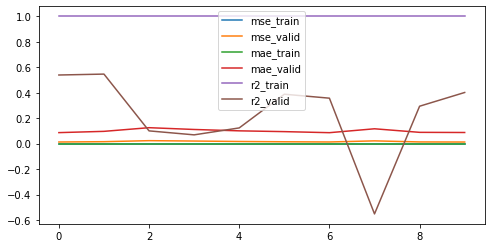

In [24]:
ax = pd.DataFrame(default_model_scores_hor).plot(figsize=(8,4))

### Hyperparameter Optimization with Time Series Cross Validation
- Bayesian optimization
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

Optimal point: [5, 198, 123]
Function value at optimal point: 0.009636107655189519


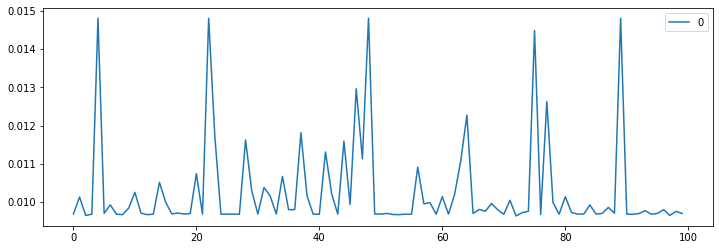

In [25]:
# objective function to minimize
def objective(params):
    max_depth, min_samples_split, min_samples_leaf = params
    model = ml_algorithm(max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf), random_state=23)
    scores = cross_validation(data_set, model, 'tau_target_hor')
    return np.mean(scores['mse_valid'])

# perform the optimization
result = gp_minimize(objective, space, n_calls=100, n_random_starts=20, acq_func='EI', acq_optimizer='auto', random_state=23, n_jobs=-1)

# optimal point and function value
print('Optimal point:', result.x)
print('Function value at optimal point:', result.fun)
ax = pd.DataFrame(result.func_vals).plot(figsize=(12,4))

### Time Series Cross Validation on Optimal Model

In [26]:
# ---------------- config opt model -----------------
opt_model_hor = ml_algorithm(max_depth=5, min_samples_split=198, min_samples_leaf=123, random_state=23)

In [27]:
opt_model_hor_tscv_scores = cross_validation(data_set, opt_model_hor, 'tau_target_hor')
opt_model_hor_tscv_scores = pd.DataFrame(opt_model_hor_tscv_scores)
display(opt_model_hor_tscv_scores)
display(opt_model_hor_tscv_scores.describe())

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
0,0.007437,0.006984,0.069211,0.063647,0.713881,0.743398
1,0.007110,0.010031,0.066939,0.081509,0.735212,0.699126
2,0.007391,0.016589,0.068113,0.107725,0.749214,0.353823
3,0.008426,0.014021,0.073536,0.100737,0.713418,0.349088
4,0.009120,0.009832,0.076913,0.081362,0.684170,0.484816
5,0.009278,0.006746,0.077748,0.065926,0.670628,0.714425
6,0.009105,0.005994,0.076867,0.060824,0.676483,0.698781
7,0.008177,0.013538,0.072139,0.098043,0.696823,0.021108
8,0.008021,0.006604,0.071139,0.065219,0.696009,0.645508
9,0.007761,0.006022,0.069700,0.062120,0.691191,0.708080


,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.008183,0.009636,0.072230,0.078711,0.702703,0.541815
std,0.000784,0.003857,0.003905,0.017898,0.025236,0.236897
min,0.007110,0.005994,0.066939,0.060824,0.670628,0.021108
25%,0.007518,0.006639,0.069333,0.064040,0.685926,0.386571
50%,0.008099,0.008408,0.071639,0.073644,0.696416,0.672144
75%,0.008935,0.012662,0.076034,0.093910,0.713765,0.705841
max,0.009278,0.016589,0.077748,0.107725,0.749214,0.743398


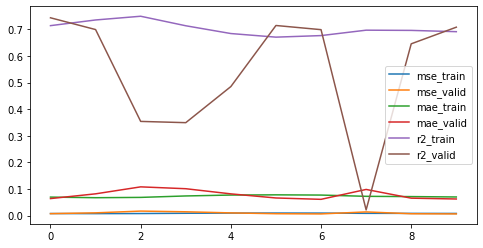

In [28]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid', 'mae_train', 'mae_valid', 'r2_train', 'r2_valid']].plot(figsize=(8,4))

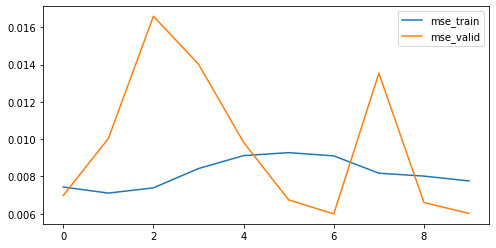

In [29]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

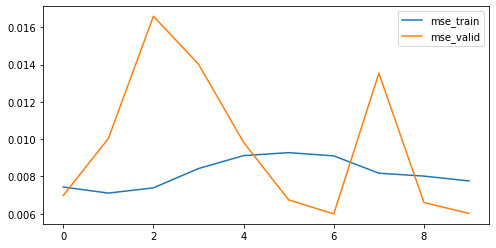

In [30]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

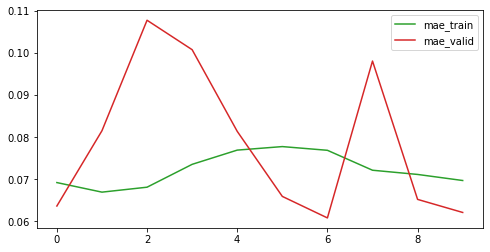

In [31]:
ax = opt_model_hor_tscv_scores[['mae_train', 'mae_valid']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

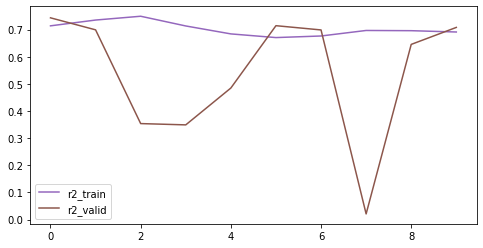

In [32]:
ax = opt_model_hor_tscv_scores[['r2_train', 'r2_valid']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

### Model Performance on Test Set

In [33]:
opt_model_hor_test_scores = performance_test_shifted(data_set, opt_model_hor, 'tau_target_hor')
opt_model_hor_test_scores = pd.DataFrame(opt_model_hor_test_scores)
display(opt_model_hor_test_scores)
display(opt_model_hor_test_scores.describe())

,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
0,0.007323,0.010016,0.068059,0.081713,0.725459,0.699590,0.429797,0.388868
1,0.007324,0.016173,0.068043,0.106396,0.750470,0.370035,0.335499,0.418695
2,0.008212,0.014182,0.072593,0.101549,0.716106,0.341591,0.293080,0.386405
3,0.008889,0.009256,0.075828,0.077690,0.689789,0.514997,0.287144,0.345439
4,0.009093,0.006853,0.076744,0.066645,0.674703,0.709906,0.295090,0.311514
5,0.008906,0.006306,0.075850,0.062273,0.680260,0.683104,0.292463,0.305481
6,0.008581,0.015458,0.074087,0.105014,0.685420,-0.117714,0.205042,0.302956
7,0.008576,0.006588,0.073951,0.065187,0.683098,0.646355,0.247086,0.257262
8,0.007779,0.006045,0.070091,0.062266,0.698437,0.706958,0.248710,0.238739
9,0.007503,0.020032,0.068751,0.124359,0.697340,-0.073832,0.342639,0.225592


,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.008219,0.011091,0.072400,0.085309,0.700108,0.448099,0.297655,0.318095
std,0.000688,0.005006,0.003404,0.022379,0.023796,0.317595,0.062015,0.066273
min,0.007323,0.006045,0.068043,0.062266,0.674703,-0.117714,0.205042,0.225592
25%,0.007572,0.006654,0.069086,0.065551,0.683678,0.348702,0.258318,0.268686
50%,0.008394,0.009636,0.073272,0.079701,0.693565,0.580676,0.292772,0.308498
75%,0.008812,0.015139,0.075393,0.104148,0.711689,0.695469,0.325397,0.376164
max,0.009093,0.020032,0.076744,0.124359,0.750470,0.709906,0.429797,0.418695


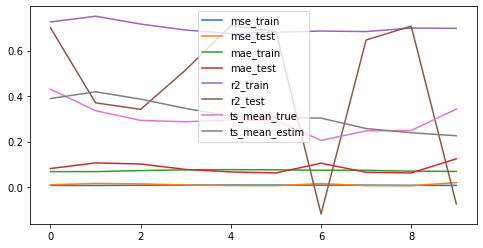

In [34]:
ax = opt_model_hor_test_scores.plot(figsize=(8,4))

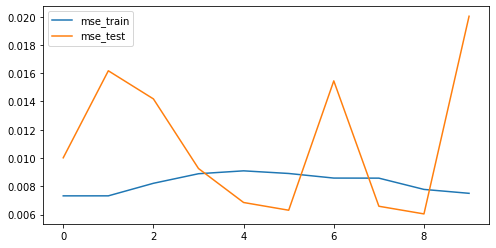

In [35]:
ax = opt_model_hor_test_scores[['mse_train', 'mse_test']].plot(figsize=(8,4))

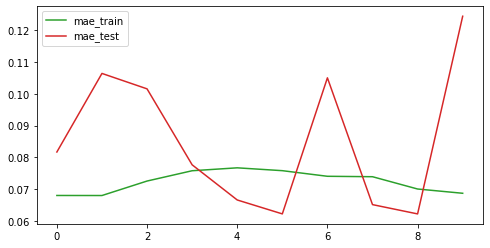

In [36]:
ax = opt_model_hor_test_scores[['mae_train', 'mae_test']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

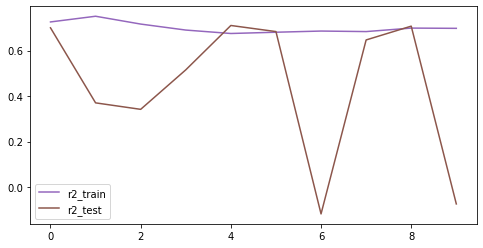

In [37]:
ax = opt_model_hor_test_scores[['r2_train', 'r2_test']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

(0.2, 0.45)

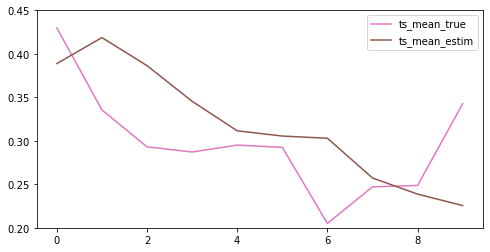

In [38]:
ax = opt_model_hor_test_scores[['ts_mean_true', 'ts_mean_estim']].plot(figsize=(8,4), color=['#e377c2', '#8c564b'])
plt.ylim([0.2,0.45])

### Data for Storage

In [39]:
results_hor = {'Model': [opt_model_ori],
            'fc_horizon': 1,
            'vif': [vif],
            'mse_tscv_t': [opt_model_hor_tscv_scores.mse_train.mean()],
            'mse_tscv_v': [opt_model_hor_tscv_scores.mse_valid.mean()],
            'mse_train': [opt_model_hor_test_scores.mse_train.mean()],
            'mse_test': [opt_model_hor_test_scores.mse_test.mean()],
               
            'mae_tscv_t': [opt_model_hor_tscv_scores.mae_train.mean()],
            'mae_tscv_v': [opt_model_hor_tscv_scores.mae_valid.mean()],
            'mae_train': [opt_model_hor_test_scores.mae_train.mean()],
            'mae_test': [opt_model_hor_test_scores.mae_test.mean()],
               
            'r2_tscv_t': [opt_model_hor_tscv_scores.r2_train.mean()],
            'r2_tscv_v': [opt_model_hor_tscv_scores.r2_valid.mean()],
            'r2_train': [opt_model_hor_test_scores.r2_train.mean()],
            'r2_test': [opt_model_hor_test_scores.r2_test.mean()],
               
            'opt_model': [opt_model_hor.get_params()],
            'ts_mean_true': opt_model_hor_test_scores.ts_mean_true.mean(),
            'ts_mean_estim': opt_model_hor_test_scores.ts_mean_estim.mean(),
              }

## Safe to Excel

In [40]:
results = pd.concat([pd.DataFrame(results_ori), pd.DataFrame(results_hor)])

display(results)

storage_name = filename + '_' + vif + '_' + str(datetime.today().day) + '.xlsx'

pd.DataFrame(results).to_excel(path + 'artifacts' + slash + storage_name, index=None)

,Model,fc_horizon,vif,mse_tscv_t,mse_tscv_v,mse_train,mse_test,mae_tscv_t,mae_tscv_v,mae_train,mae_test,r2_tscv_t,r2_tscv_v,r2_train,r2_test,opt_model,ts_mean_true,ts_mean_estim
0,"DecisionTreeRegressor(max_depth=6, min_samples_leaf=167, min_samples_split=45,\n random_state=23)",0,vif_10,0.003853,0.004856,0.003897,0.004949,0.048699,0.054943,0.049035,0.055776,0.861631,0.776809,0.860714,0.767635,"{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 167, 'min_samples_split': 45, 'min_weight_fraction_leaf': 0.0, 'random_state': 23, 'splitter': 'best'}",0.296046,0.308584
0,"DecisionTreeRegressor(max_depth=6, min_samples_leaf=167, min_samples_split=45,\n random_state=23)",1,vif_10,0.008183,0.009636,0.008219,0.011091,0.072230,0.078711,0.072400,0.085309,0.702703,0.541815,0.700108,0.448099,"{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 123, 'min_samples_split': 198, 'min_weight_fraction_leaf': 0.0, 'random_state': 23, 'splitter': 'best'}",0.297655,0.318095
